In [1]:
import pandas as pd
import numpy as np
from bq_helper import BigQueryHelper
from blockchain import blockexplorer
from blockchain import util
import time
from tqdm import tqdm
from collections import Counter
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import queue as Q

In [3]:
# unit in satoshi
# testing api call
address = blockexplorer.get_address('3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB')
address2 = blockexplorer.get_address('3EXxYoB61g13UsH1K678G5zeEE8W3XJ2p3')
address3 = blockexplorer.get_address('1NqdBaU9WCvmjGQ1omPx6NHGJYzQo9udd6')
print(address.total_received)
print(address.total_sent)
print(address.final_balance)
print(address.n_tx)
print(address.transactions[0].hash)

655000000000
654990000000
10000000
43
c7ae6fb55b5919bf8239555a11f0309527bac4f18bdc5b9f98fbcd7bf7e83342


idea: use bfs to expand adr to explore. 

for simplicity, neglect amount of transfer for now

for transacitons going out of Target Address, not so interested right now

problem: how to distinguish incoming or outgoing tx?

timeout: The read operation timed out
possible solution: request API key?

before: want to search by distance/radius. now: search by number of nodes to visit

neo4j: transaction/address as vertex. inputs. outputs. 

In [61]:
address = '3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB'
TA = '3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB'
total_received = blockexplorer.get_address(address).total_received
top_k = 10
tx_queue = []
addr_queue = []
addr_queue.append((address, total_received))
addr_dict_list = [] # key:str address, value: amount
degree = 4
degree_count = 0
max_iter = 1
q = Q.PriorityQueue()
max_nodes = 300
while degree > 0:
    addr_dict = dict()
    addr_dict_list.append(addr_dict)
    print ("doing degree = " + str(degree_count) + " search, " + "number of nodes to explore (with duplicates): " + str(max_iter))
    for i in (range(max_iter)):
        from_address, amount = addr_queue.pop(0)
        #G.add_node(from_address)
        if from_address not in addr_dict:
            addr = blockexplorer.get_address(from_address)
            tx_queue.extend(addr.transactions)
            addr_dict[from_address] = amount
        else:
            addr_dict[from_address] += amount
        all_amount_allocated = False
        while len(tx_queue) > 0 and not all_amount_allocated:
            tx = tx_queue.pop(0)
            isReceiver = False;
            # check if this addr is receiving money
            for out in tx.outputs:
                if addr.address == out.address:
                    isReceiver = True;
                    if out.value < amount:
                        money_received = out.value
                        amount -= out.value
                    else:
                        money_received = amount
                        all_amount_allocated = True
                    break;
            if isReceiver:
                for inp in tx.inputs:
                    # algorithm here could be wrong
                    if addr.address == out.address:
                        if inp.value < money_received:
                            money_received -= inp.value
                            money_edge = inp.value
                        else:
                            money_edge = money_received
                    if q.qsize() < max_nodes:
                        q.put((money_edge, inp.address, addr.address))
                    else:
                        (out_edge, out_inpaddr, out_addr) = q.get()
                        if money_edge > out_edge:
                            q.put((money_edge, inp.address, addr.address))
                        else:
                            q.put((out_edge, out_inpaddr, out_addr))
                    #G.add_weighted_edges_from([(inp.address, addr.address, money_edge)])
                    addr_queue.append((inp.address, money_edge))
    max_iter = len(addr_queue)
    degree -= 1
    degree_count += 1
    filename = "address_degree_" + str(degree_count)
    with open(filename, 'w') as f:
        for inp_addr,_  in addr_queue:
            f.write("%s\n" % inp_addr)
    scores = Counter(addr_dict)
    for addr, values in scores.most_common(top_k):
        print (addr, values, str(values/total_received * 100) + "%")
    #print ("top " + str(top_k) +" addresses total:  " + str(total) + "    " +str(total/total_received*100) + "%")

doing degree = 0 search, number of nodes to explore (with duplicates): 1
3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB 655000000000 100.0%
doing degree = 1 search, number of nodes to explore (with duplicates): 91
39ACzDZRJBd1STHgvL5AMQvo48iqMoEdSS 30000000000 4.580152671755725%
3PpXuqu2KG4WZmHyFp2XyU5gmaFDxmxJJ1 25000000000 3.816793893129771%
3QxkG5HitPoXsjTfogMk4AYqj4TJhJnZGH 25000000000 3.816793893129771%
3CLon2XMt7yBuVrqtPBw5cW9o93dJeAknM 25000000000 3.816793893129771%
3E9CYFsCiDtQ4xaxsj1hcZLUh8hwpimioj 25000000000 3.816793893129771%
3QiLXF8tpa17k9XLZ4rbcoXTKJDoWsNaGG 20000000000 3.0534351145038165%
3MWaY5qReHm3qqnhgYCE437cVD4moWeUys 20000000000 3.0534351145038165%
33SBjyCNDr499kFkg93nxchtRg9ij38H2C 20000000000 3.0534351145038165%
3QEvTTqJ5eCcXYy2p7jJEtqH4xFnyCjXme 20000000000 3.0534351145038165%
37D1iDiquoAW875RXjvPc6HRgsmsLriDbo 20000000000 3.0534351145038165%
doing degree = 2 search, number of nodes to explore (with duplicates): 170
33LjX6NywVE2Lnbuk5BZjTvTbQt8cNNe1A 40000000000 6.106870229

APIException: Illegal character l at position 16

In [39]:
G=nx.DiGraph()
G.add_node(TA)
for i in range(max_nodes):
    (out_edge, out_inpaddr, out_addr) = q.get()
    G.add_weighted_edges_from([(out_inpaddr, out_addr, out_edge)])


In [58]:
scores = Counter(addr_dict)
for addr, values in scores.most_common(top_k):
    print (addr, values, str(values/total_received * 100) + "%")

33LjX6NywVE2Lnbuk5BZjTvTbQt8cNNe1A 64998918119 9.92349894946565%
3HP7LCq8a8RS6sz1SYqPPZ3V7HH1odGKxP 45490708504 6.94514633648855%
3QehEc9kj4DgKrP1fYAccLg9RgAKAK6XuX 30000000000 4.580152671755725%
3ESJe7jsjhJrHk9dkvvbqYfscRnrZnwSJx 25000000000 3.816793893129771%
3NSLeRUGq9pWFuJJjcnvHxRP7SV7g2nNbU 25000000000 3.816793893129771%
1Kr6QSydW9bFQG1mXiPNNu6WpJGmUa9i1g 22980918629 3.508537195267176%
1z7kt5SRhxQXayn6C8UVPo8PuETNntzR3 19397935041 2.9615168001526717%
1BG1cD1zRv3zkDyXjRZ8mbV31ZSmyRpkVd 15000000000 2.2900763358778624%
3DP4WQKutagTkHRKC7Ko2aU2biqnvirSH2 14999936651 2.290066664274809%
3DJhuKechuQZnQqFbuqLxNJ9Km6bYPYBZR 10000000000 1.5267175572519083%


In [59]:
iAdr = '3MWaY5qReHm3qqnhgYCE437cVD4moWeUys'
print (addr_dict_list[1][iAdr])
print (addr_dict_list[2][iAdr])
final_dict = dict()
for addr_dict in addr_dict_list:
    for k,v in addr_dict.items():
        if k not in final_dict:
            final_dict[k] = v
        else:
            final_dict[k] += v
print (len(final_dict))

20000000000
30000000000
365


In [60]:
scores = Counter(final_dict)
for addr, values in scores.most_common(top_k):
    print (addr, values, str(values/total_received * 100) + "%")

3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB 655000000000 100.0%
33LjX6NywVE2Lnbuk5BZjTvTbQt8cNNe1A 104998918119 16.030369178473283%
3ESJe7jsjhJrHk9dkvvbqYfscRnrZnwSJx 65000000000 9.923664122137405%
3MWaY5qReHm3qqnhgYCE437cVD4moWeUys 50000000000 7.633587786259542%
3QehEc9kj4DgKrP1fYAccLg9RgAKAK6XuX 50000000000 7.633587786259542%
3HP7LCq8a8RS6sz1SYqPPZ3V7HH1odGKxP 45490736005 6.945150535114504%
33SBjyCNDr499kFkg93nxchtRg9ij38H2C 45000000000 6.870229007633588%
3NSLeRUGq9pWFuJJjcnvHxRP7SV7g2nNbU 45000000000 6.870229007633588%
3AzK8em6MeGgZkvDnrzRQS1p1dS4Hkg9KY 40000000000 6.106870229007633%
3E7DcbGJ3XEzffUCKHQw9HorzLc5NiiANC 40000000000 6.106870229007633%


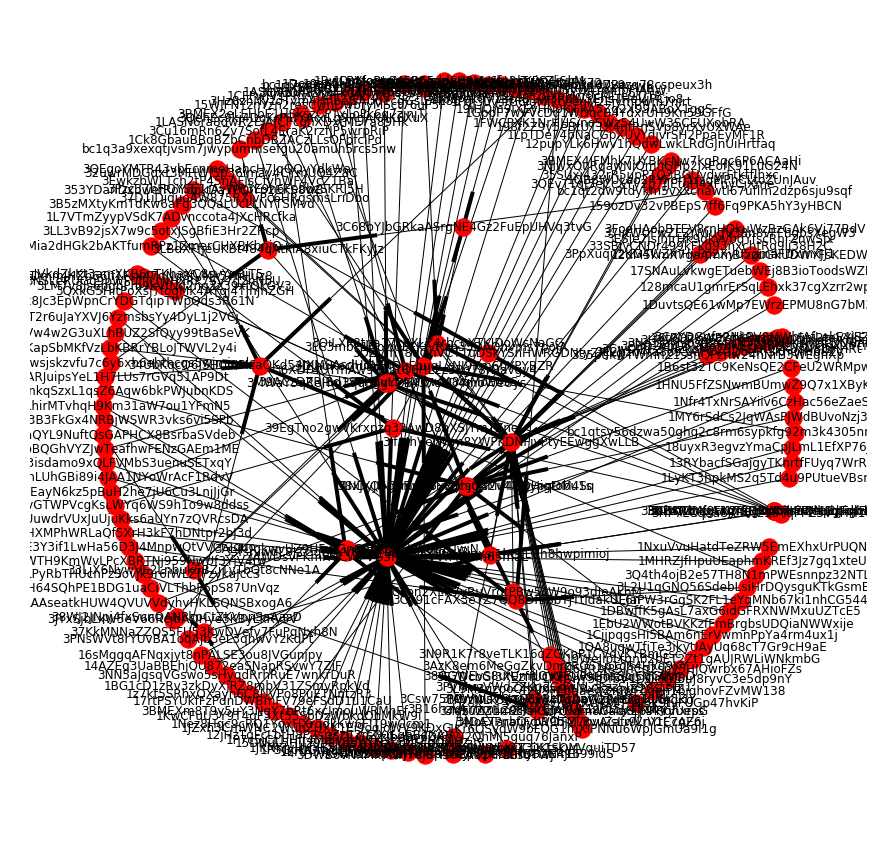

In [35]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
nx.draw_networkx(G,pos=nx.spring_layout(G))
plt.axis('off')
plt.show()

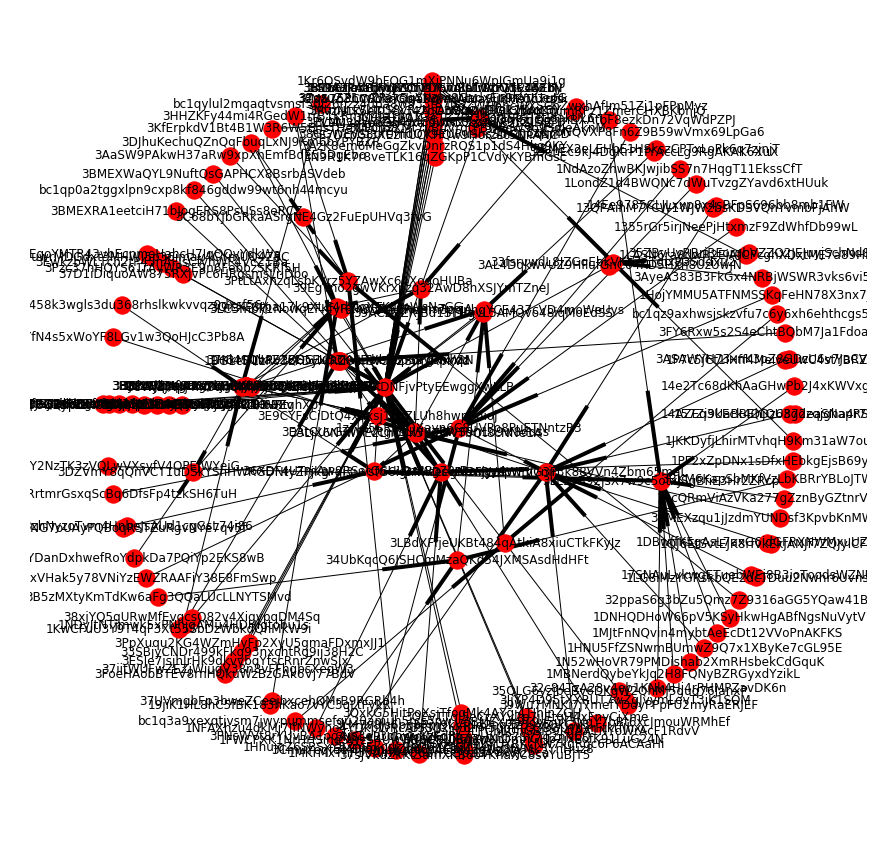

In [40]:
matplotlib.rcParams['figure.figsize'] = [15, 15]
nx.draw_networkx(G,pos=nx.spring_layout(G))
plt.axis('off')
plt.show()

In [36]:
print (len(addr_queue))
print (len(G))
print (len(tx_queue))
print (TA)

608
181
0
3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB


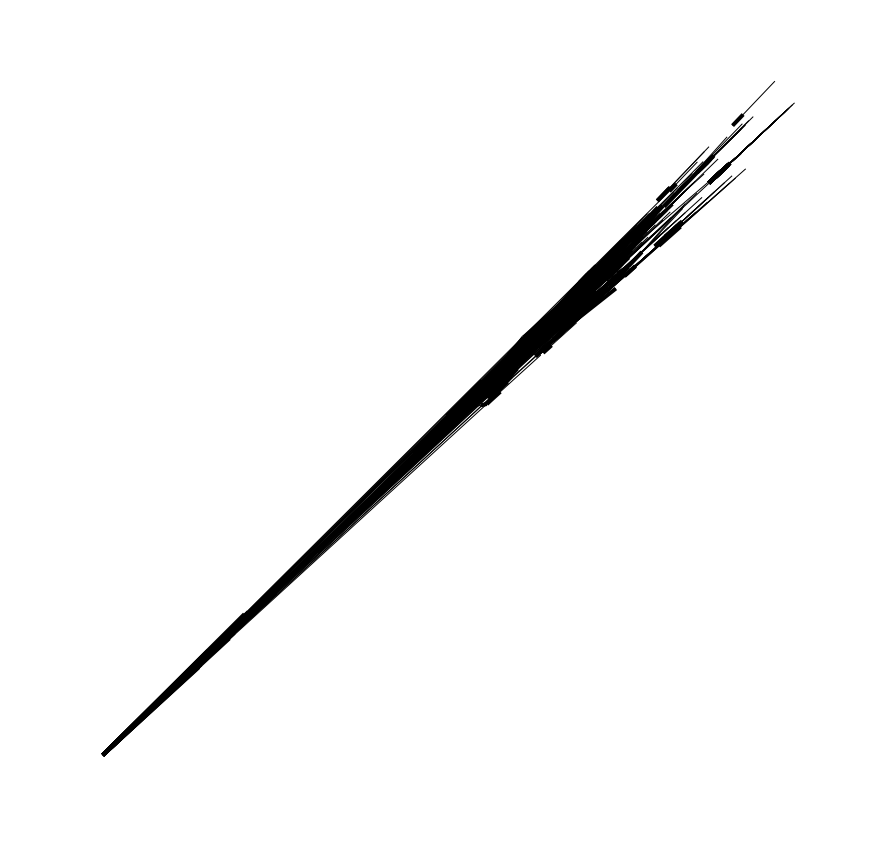

In [109]:
matplotlib.rcParams['figure.figsize'] = [15, 15] 
#edges=sorted(G.edges(data=True), key=lambda t: t[2].get('weight', 1))
nx.draw_networkx_edges(G, pos=nx.spring_layout(G), edgelist = edges[:1000])
plt.axis('off')
plt.show()

# Trying to reduce number of edges to draw in the graph, current number is too high

In [12]:
#Extract edges into numpy array 
edges =  nx.to_numpy_matrix(G, nodelist= G.nodes())

In [98]:
print (edges.shape)
row_sum = edges.sum(axis=1)
n_nodes = 1000
indices = row_sum.argsort(axis=0)[-n_nodes:][::-1]
ind = indices.reshape(n_nodes,).tolist()[0]
tmp_matrix = edges[ind, :]
tmp2_matrix = tmp_matrix[:, ind]
print (tmp_matrix.shape)
print (tmp2_matrix.shape)

(11121, 11121)
(1000, 11121)
(1000, 1000)


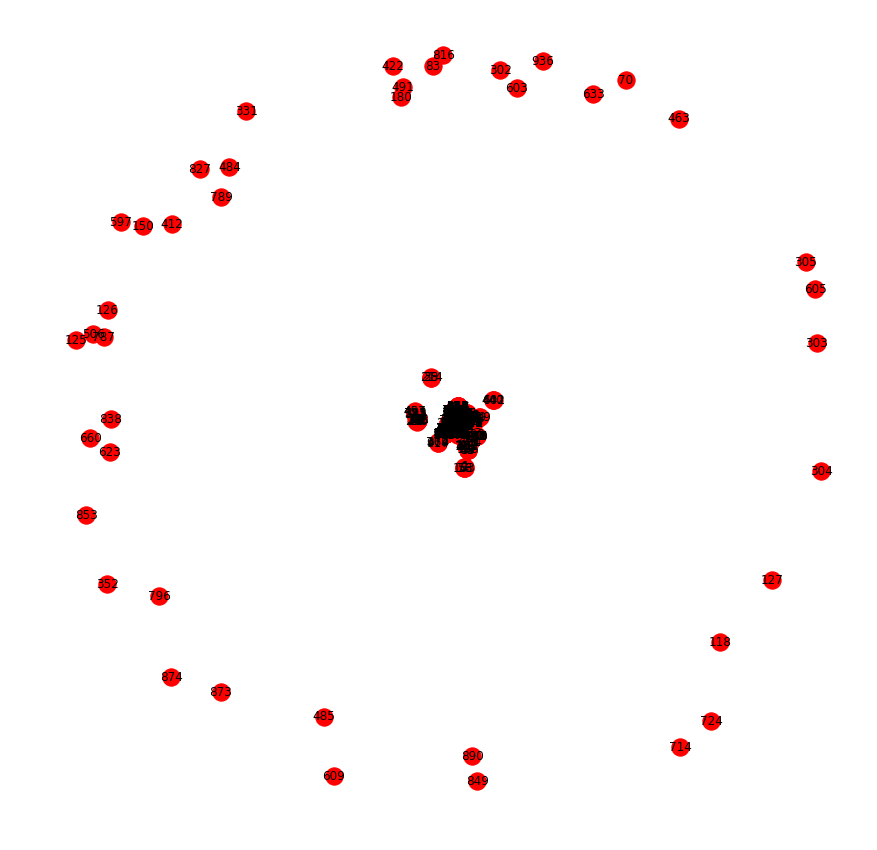

In [101]:
#Save the modified graph
G2 = nx.from_numpy_matrix(tmp2_matrix)
nx.draw_networkx(G2)
#pos=nx.spring_layout(G2)
#nx.draw_networkx_nodes(G2,pos)
#nx.draw_networkx_edges(G2,pos)
plt.axis('off')
plt.show() 

In [ ]:
with open(filename, 'w') as f:
    for inp_addr,_ , _ in addr_queue:
        f.write("%s\n" % inp_addr)
print ("degree " + str(degree_count)+ " total number of nodes " + str(len(G)))

In [ ]:
matplotlib.rcParams['figure.figsize'] = [15, 15] 
nx.draw_networkx(G)
plt.show()

In [ ]:
print (len(addr_queue))
print (max_iter)

Explanation: After use BFS to visit first 1000 (with duplicates)addresses, there are in fact 415 unique nodes. And the nodes to be explored reach 21080. Total time taken locally is 10min. 

With this much exploration: top 5 addresses are listed above, the number associated is the number of transactions related to TA. '1NDyJtNTjmwk5xPNhjgAMu4HDHigtobu1s' is an interesting one with 285 transacitons. (Maybe should count total number of transacitons related to TA, but this metric can be changed into amount of BTC later)

In [ ]:
TA = blockexplorer.get_address('3JfAJhVeDwm8YWPKDNFjvPtyEEwggXwLLB')
print (TA.total_received)
scores = Counter(addr_dict)
total = 0
for addr, values in scores.most_common(len(addr_dict)):
    total += values
    print (addr, values, str(values/TA.total_received * 100) + "%")
print ("total   " + str(total) + "    " +str(total/TA.total_received*100) + "%")